In [1]:
!pip install kaggle --quiet
from google.colab import files
files.upload()

import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d fedesoriano/heart-failure-prediction

!unzip -q heart-failure-prediction.zip -d heart_data

import pandas as pd
df = pd.read_csv("heart_data/heart.csv")
df.head()



Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction
License(s): ODbL-1.0
  0% 0.00/8.56k [00:00<?, ?B/s]
100% 8.56k/8.56k [00:00<00:00, 26.1MB/s]


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


Step 1: Download and Load Heart Failure Prediction Dataset

Installed Kaggle API to fetch datasets programmatically.

Uploaded kaggle.json to authenticate with Kaggle.

Downloaded the “Heart Failure Prediction Dataset” from Kaggle.

Unzipped the dataset into folder heart_data.

Loaded the CSV file into a pandas dataframe df.

Displayed the first few rows with df.head() to verify successful.

In [2]:
df.info()
print(df.isnull().sum())
df = df.drop_duplicates()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB
Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST

Step 2: Data Cleaning – Check Missing Values and Duplicates

Checked the dataset information using df.info().

Verified missing values with df.isnull().sum() → no missing values found.

Checked for duplicate rows → df.drop_duplicates() removes any duplicates (none found in this dataset).

Dataset is clean and ready for preprocessing.

In [3]:
df.duplicated().sum()

np.int64(0)

In [4]:
df['HeartDisease'].value_counts()

,count
HeartDisease,
1,508
0,410


In [5]:
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
df_encoded = df.copy()
categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])
X = df_encoded.drop("HeartDisease", axis=1)
y = df_encoded["HeartDisease"]
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print("Before SMOTE:\n", y.value_counts())
print("After SMOTE:\n", y_res.value_counts())

Before SMOTE:
 HeartDisease
1    508
0    410
Name: count, dtype: int64
After SMOTE:
 HeartDisease
0    508
1    508
Name: count, dtype: int64


Step 3: Encoding Categorical Features and Handling Class Imbalance

Encoding Categorical Variables
We converted categorical columns (Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope) into numerical values using LabelEncoder. This is necessary because machine learning models and SMOTE cannot process string values directly.

Separating Features and Target

X contains all input features.

y contains the target variable HeartDisease.

Balancing Classes with SMOTE
The original dataset was slightly imbalanced:

Heart disease = 1 → 508 samples

No heart disease = 0 → 410 samples

We applied SMOTE (Synthetic Minority Oversampling Technique) to oversample the minority class so that both classes have equal representation. This helps prevent the models from being biased toward the majority class.

Output after SMOTE:

Before: 1 → 508, 0 → 410

After: 1 → 508, 0 → 508

This ensures a balanced dataset, ready for classification modeling.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Training data shape:", X_train_scaled.shape)
print("Test data shape:", X_test_scaled.shape)

Training data shape: (812, 11)
Test data shape: (204, 11)


Step 4: Train Test Split and Feature Scaling

Splitting the Dataset
The resampled dataset is divided into training and testing sets using train_test_split:

80% for training

20% for testing
We used stratify=y_res to ensure the class distribution remains balanced in both sets.

Feature Scaling
We applied StandardScaler to scale the features:

This standardizes each feature to have a mean of 0 and standard deviation of 1.

Scaling is important for algorithms like K Nearest Neighbors and Gradient Descent-based models to perform well.

Output Shapes

Training data: (X_train_scaled.shape)

Test data: (X_test_scaled.shape)

This prepares the data for model training and ensures faster convergence and better performance.

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
dt_scores = cross_val_score(dt, X_train_scaled, y_train, cv=cv, scoring='accuracy')
knn = KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train_scaled, y_train, cv=cv, scoring='accuracy')

print("Decision Tree CV Accuracy:", dt_scores.mean())
print("KNN CV Accuracy:", knn_scores.mean())

Decision Tree CV Accuracy: 0.7943724911005074
KNN CV Accuracy: 0.8608649549344844


Step 5: Model Training and Cross Validation

Models Used

Decision Tree Classifier (DT): A tree-based model that splits data based on feature values to make predictions.

K-Nearest Neighbors (KNN): A distance-based algorithm that classifies a sample based on the majority class of its neighbors.

Cross-Validation

We used Stratified 5-Fold Cross-Validation to evaluate model performance reliably.

StratifiedKFold ensures each fold preserves the original class distribution.

Accuracy is used as the scoring metric.

Results

dt_scores.mean() gives the average cross-validation accuracy for the Decision Tree.

knn_scores.mean() gives the average cross-validation accuracy for KNN.

This step helps compare models and select the one with better generalization before final evaluation on the test set.

In [8]:
from sklearn.model_selection import GridSearchCV
dt_params = {
    'max_depth': [3, 5, 7, 10, None],
    'criterion': ['gini', 'entropy']
}
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
dt_grid.fit(X_train_scaled, y_train)

knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=knn_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)
knn_grid.fit(X_train_scaled, y_train)

print("Best Decision Tree Params:", dt_grid.best_params_)
print("Best Decision Tree CV Accuracy:", dt_grid.best_score_)
print("Best KNN Params:", knn_grid.best_params_)
print("Best KNN CV Accuracy:", knn_grid.best_score_)


Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': 5}
Best Decision Tree CV Accuracy: 0.8522305536620465
Best KNN Params: {'n_neighbors': 9, 'weights': 'distance'}
Best KNN CV Accuracy: 0.8694539119896995


Step 6: Hyperparameter Tuning using GridSearchCV

Purpose

To find the best hyperparameters for our models (Decision Tree and KNN) that maximize cross-validation accuracy.

This helps improve model performance and prevent underfitting or overfitting.

Decision Tree Hyperparameters

max_depth: Maximum depth of the tree to control complexity.

criterion: Function to measure split quality (gini or entropy).

KNN Hyperparameters

n_neighbors: Number of neighbors to consider for voting.

weights: Weighting function for neighbors (uniform for equal weight, distance for closer neighbors weighted more).

GridSearchCV

Performs an exhaustive search over specified hyperparameter values using 5 fold cross validation.

n_jobs=-1 uses all CPU cores to speed up computation.

Results

best_params_ gives the optimal hyperparameters for each model.

best_score_ gives the best cross validation accuracy achieved with those parameters.

This step ensures the models are fine tuned for maximum predictive performance.

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

best_dt = dt_grid.best_estimator_
best_knn = knn_grid.best_estimator_

y_pred_dt = best_dt.predict(X_test_scaled)
y_pred_knn = best_knn.predict(X_test_scaled)

print("Decision Tree Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

print("\nKNN Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1 Score:", f1_score(y_test, y_pred_knn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))


Decision Tree Results:
Accuracy: 0.8676470588235294
Precision: 0.8640776699029126
Recall: 0.8725490196078431
F1 Score: 0.8682926829268293

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.86      0.87       102
           1       0.86      0.87      0.87       102

    accuracy                           0.87       204
   macro avg       0.87      0.87      0.87       204
weighted avg       0.87      0.87      0.87       204


KNN Results:
Accuracy: 0.8529411764705882
Precision: 0.9
Recall: 0.7941176470588235
F1 Score: 0.84375

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       102
           1       0.90      0.79      0.84       102

    accuracy                           0.85       204
   macro avg       0.86      0.85      0.85       204
weighted avg       0.86      0.85      0.85       204



Step 7: Model Evaluation on Test Data

Purpose

To evaluate the performance of the best tuned Decision Tree and KNN models on unseen test data.

We use multiple metrics to get a complete picture of model effectiveness.

Evaluation Metrics

Accuracy: Overall correctness of the model.

Precision: Correct positive predictions out of all predicted positives.

Recall: Correct positive predictions out of all actual positives.

F1 Score: Harmonic mean of precision and recall, balances both.

Classification Report: Detailed breakdown of all metrics for each class.

Process

Use best_estimator_ from GridSearchCV to get the optimized model.

Predict the target variable on X_test_scaled.

Calculate metrics using sklearn.metrics functions.

Results Interpretation

Compare Decision Tree and KNN metrics to identify the better performing model.

Helps in understanding trade offs between precision, recall, and overall accuracy.

This step ensures that the selected model is robust and reliable for predicting heart disease on new data.

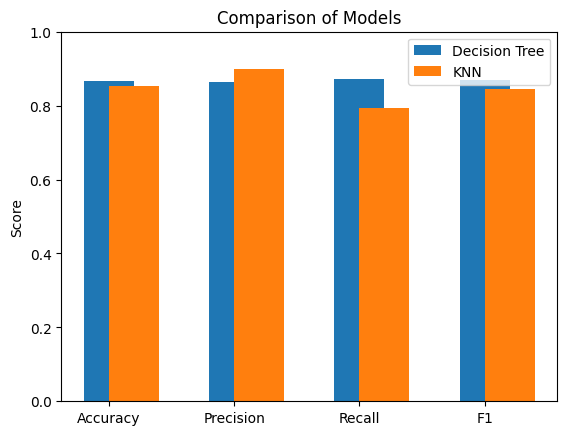

In [10]:
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
dt_scores = [0.8676, 0.8641, 0.8725, 0.8683]
knn_scores = [0.8529, 0.9, 0.7941, 0.8438]

x = range(len(metrics))
plt.bar(x, dt_scores, width=0.4, label='Decision Tree', align='center')
plt.bar(x, knn_scores, width=0.4, label='KNN', align='edge')
plt.xticks(x, metrics)
plt.ylim(0, 1)
plt.ylabel('Score')
plt.title('Comparison of Models')
plt.legend()
plt.show()


Step 8: Visualizing Model Performance

In this step, we compare the performance of the Decision Tree and K-Nearest Neighbors (KNN) classifiers using a bar chart. The metrics considered are Accuracy, Precision, Recall, and F1 Score.

dt_scores and knn_scores contain the respective scores of the two models on the test dataset.

A bar chart is plotted using Matplotlib to visually compare how each model performs across different evaluation metrics.

This visualization helps quickly identify which model performs better in each metric and provides an intuitive comparison of their overall performance.

By analyzing the chart, we can make informed decisions about which model is more suitable for predicting heart disease in this dataset.